In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch
from torch import nn,functional
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
# from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import os
# print(os.listdir("../input"))

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
train_batch_size =107
test_batch_size =107

In [10]:
df = pd.read_csv('mnist_train.csv')
print(df.shape)
df.iloc[:,0]


(60000, 785)


0        5
1        0
2        4
3        1
4        9
        ..
59995    8
59996    3
59997    5
59998    6
59999    8
Name: label, Length: 60000, dtype: int64

In [72]:
#Loading the data
train = pd.read_csv("mnist_train.csv")
print(type(train))
X = train.loc[:,train.columns != "label"].values/255   #Normalizing the values
Y = train.label.values

features_train, features_test, targets_train, targets_test = train_test_split(X,Y,test_size=0.2,
                                                                              random_state=42)
X_train = torch.from_numpy(features_train)
X_test = torch.from_numpy(features_test)

Y_train = torch.from_numpy(targets_train).type(torch.LongTensor) 
Y_test = torch.from_numpy(targets_test).type(torch.LongTensor)

train = torch.utils.data.TensorDataset(X_train,Y_train)
test = torch.utils.data.TensorDataset(X_test,Y_test)
print(type(train))

train_loader = torch.utils.data.DataLoader(train, batch_size = train_batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = test_batch_size, shuffle = False)

<class 'pandas.core.frame.DataFrame'>
<class 'torch.utils.data.dataset.TensorDataset'>


tensor(4)


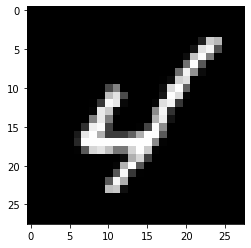

In [94]:
classes = ['0','1','2','3','4','5','6','7','8','9']
index =19
plt.imshow(X_train.cpu()[index].reshape((28, 28)), cmap="gray")
print(Y_train[index])

In [74]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 5, stride=1, padding=0)
        self.cnn_2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, stride=1, padding=0)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(p=0.2)
        self.dropout2d = nn.Dropout2d(p=0.2)
        
        self.fc1 = nn.Linear(32 * 4 * 4, 128) 
        self.fc2 = nn.Linear(128, 64) 
        self.out = nn.Linear(64, 10) 
        
    def forward(self,x):
        
        out = self.cnn_1(x)
        out = self.relu(out)
        out = self.dropout2d(out)
        out = self.maxpool(out)
        
        out = self.cnn_2(out)
        out = self.relu(out)
        out = self.dropout2d(out)
        out = self.maxpool(out)
        
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.dropout(out)
        out = self.out(out)
        
        return out
        
        

In [75]:
model = CNN()
model = model.double()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.003)

In [76]:
epochs = 15
train_losses, test_losses = [] ,[]
for epoch in range(epochs):
    running_loss = 0
    for images,labels in train_loader:
        train = Variable(images.view(-1,1,28,28))
        labels = Variable(labels)
        
        optimizer.zero_grad()
        
        output = model(train)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad(): #Turning off gradients to speed up
            model.eval()
            for images,labels in test_loader:
                
                test = Variable(images.view(-1,1,28,28))
                labels = Variable(labels)
                
                log_ps = model(test)
                test_loss += criterion(log_ps,labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim = 1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        model.train()        
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy*100/len(test_loader)))
        
    PATH = './saved_model.pth'
    torch.save(model.state_dict(), PATH)
    print("Model Saved! at epoch no.: {}".format(epoch+1))     

Epoch: 1/15..  Training Loss: 0.260..  Test Loss: 0.072..  Test Accuracy: 97.850
Model Saved! at epoch no.: 1
Epoch: 2/15..  Training Loss: 0.105..  Test Loss: 0.060..  Test Accuracy: 98.348
Model Saved! at epoch no.: 2
Epoch: 3/15..  Training Loss: 0.088..  Test Loss: 0.053..  Test Accuracy: 98.429
Model Saved! at epoch no.: 3
Epoch: 4/15..  Training Loss: 0.082..  Test Loss: 0.049..  Test Accuracy: 98.611
Model Saved! at epoch no.: 4
Epoch: 5/15..  Training Loss: 0.074..  Test Loss: 0.069..  Test Accuracy: 98.183
Model Saved! at epoch no.: 5
Epoch: 6/15..  Training Loss: 0.074..  Test Loss: 0.050..  Test Accuracy: 98.627
Model Saved! at epoch no.: 6
Epoch: 7/15..  Training Loss: 0.068..  Test Loss: 0.057..  Test Accuracy: 98.456
Model Saved! at epoch no.: 7
Epoch: 8/15..  Training Loss: 0.068..  Test Loss: 0.055..  Test Accuracy: 98.635
Model Saved! at epoch no.: 8
Epoch: 9/15..  Training Loss: 0.067..  Test Loss: 0.055..  Test Accuracy: 98.539
Model Saved! at epoch no.: 9
Epoch: 10/

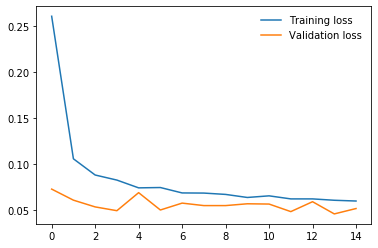

In [95]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [96]:
test_images = pd.read_csv("mnist_test.csv")
test_image = test_images.loc[:,test_images.columns != "label"].values/255
test_dataset = torch.from_numpy(test_image)
#test_dataset_1 = torch.utils.data.TensorDataset(test_dataset)
new_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 100, shuffle = False)

In [97]:
results = []
with torch.no_grad():
    model.eval()
    for images in new_test_loader:
        test = Variable(images.view(-1,1,28,28))
        output = model(test)
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim = 1)
        results += top_class.numpy().tolist()

In [102]:
np.shape(results)

(10000, 1)

In [106]:
predictions = np.array(results).flatten()

In [107]:
np.shape(predictions)

(10000,)

In [99]:
submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": predictions})
submissions.to_csv("my_submissions.csv", index=False, header=True)

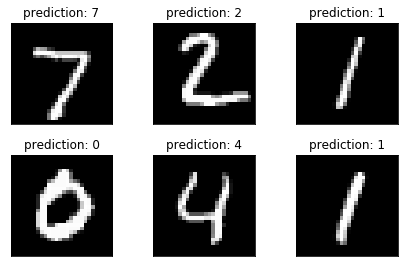

In [119]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(test_dataset.cpu()[i].reshape((28, 28)), cmap="gray")
  plt.title("prediction: {}".format(predictions[i]))
  plt.xticks([])
  plt.yticks([])
    

In [117]:
sub = pd.read_csv('my_submissions.csv')
print(sub.head(6))

   ImageId  Label
0        1      7
1        2      2
2        3      1
3        4      0
4        5      4
5        6      1
